In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/theo/MVA/graph_mlc/src


In [3]:
from util import *
from params import *
from imports import *

from data.dataset import *
from data.transforms import *

from model_zoo.common import *
from model_zoo.mlgcn import *

from training.train import *
from training.freezing import *

In [4]:
seed_everything(SEED)

# Datasets

In [5]:
trainval_dataset = MLCDataset(TRAINVAL_IMGS, 
                              transforms=get_transfos(size=IMG_SIZE),
                              img_path=IMG_PATH,
                              annotation_path=ANNOTATION_PATH
                             )

In [6]:
test_dataset = MLCDataset(TEST_IMGS, 
                          transforms=get_transfos(test=True, size=IMG_SIZE),
                          img_path=IMG_PATH,
                          annotation_path=ANNOTATION_PATH
                         )

# Loading GloVe Embeddings

In [7]:
os.listdir(GLOVE_PATH)

['glove.6B.300d.txt',
 'glove.6B.200d.txt',
 'glove.6B.50d.txt',
 'glove.6B.100d.txt']

In [8]:
embeddings_dict = {}
with open(GLOVE_PATH + f"glove.6B.{GLOVE_DIM}d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [9]:
embeddings_dict['diningtable'] = embeddings_dict['table']
embeddings_dict['pottedplant'] = embeddings_dict['plant']
embeddings_dict['tvmonitor'] = embeddings_dict['tv']

In [10]:
class_embeddings = np.zeros((NUM_CLASSES, GLOVE_DIM))

In [11]:
for c in range(len(CLASSES)):
    try:
        class_embeddings[c, :] = np.array(embeddings_dict[CLASSES[c]])
    except:
        print(f"No embedding found for {c}")

In [12]:
class_embeddings.shape

(20, 300)

# Bert Embeddings

In [13]:
from transformers import * 

In [14]:
pretrained_weights = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pretrained_weights)

In [15]:
model = BertModel.from_pretrained(pretrained_weights, output_hidden_states=False, output_attentions=False)

In [16]:
input_ids = torch.tensor([tokenizer.encode([c]) for c in CLASSES])

In [17]:
encodings = model(input_ids)[0][:, 0]

In [18]:
bert_embeddings = encodings.detach().numpy()

# Building Coocurence Matrix

In [19]:
THRESHOLD = 0.25
P = 0.25

In [20]:
y = trainval_dataset.y.astype(int)

In [21]:
ocurences = np.repeat(np.sum(y, 0, keepdims=True), NUM_CLASSES, axis=0)
union = (ocurences + ocurences.T) / 2

In [22]:
coocurence = y.T @ y # / union

In [23]:
coocurence = (coocurence / y.sum(0)).T

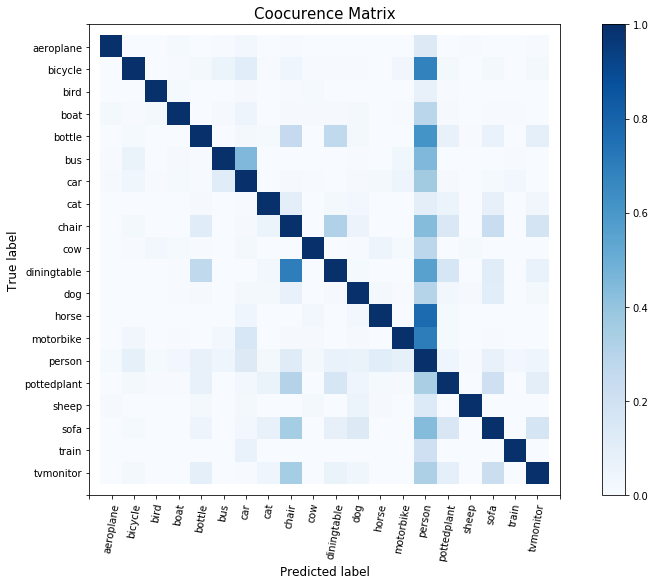

In [24]:
plot_coocurence(coocurence, CLASSES)

In [25]:
A = threshold_and_smooth_matrix(coocurence, t=THRESHOLD, p=P)
# A = (coocurence > THRESHOLD).astype(int)

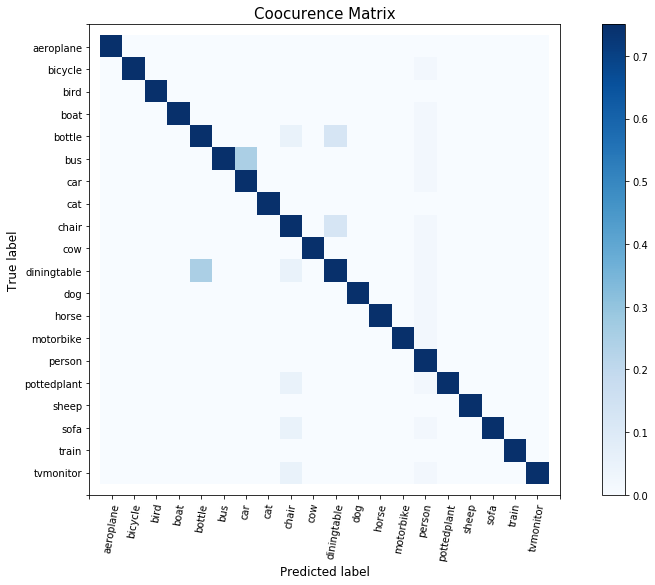

In [26]:
plot_coocurence(A, CLASSES)

In [27]:
# np.save('../output/mlgcn_A.npy', A)

# Model

In [28]:
def train_mlgcn(backbone, train_dataset, val_dataset, num_classes, A, class_embeddings, 
                test_dataset=None, cp=False, model_name='model'):
    
    seed_everything(SEED)
    model = GCNClassifier(backbone, num_classes, A, class_embeddings, n_gcns=2, use_bias=False).cuda()

    print('\n- Training with frozen backbone : ')

    freeze(model)
    for layer in ['gcns', 'clf_bias']:
        unfreeze_layer(model, layer)

    n_parameters = count_parameters(model)
    print(f'    -> {n_parameters} trainable parameters\n')

    fit(model, train_dataset, val_dataset, epochs=10, batch_size=32, warmup_prop=0, lr=1e-3, min_lr=1e-4,
        verbose=1, verbose_eval=1, cp=False, model_name='model')

    print('\n- Training : ')

    if backbone == 'resnet34':
        unfreeze(model)
    else:
        unfreeze_layer(model, 'layer4')
        
    n_parameters = count_parameters(model)
    print(f'    -> {n_parameters} trainable parameters\n')

    fit(model, train_dataset, val_dataset, epochs=5, batch_size=16, warmup_prop=0, lr=1e-4, min_lr=1e-6,
        verbose=1, verbose_eval=1, cp=cp, model_name=model_name)

    print('\n- Evaluating: \n')

    if cp:
        load_model_weights(model, model_name, verbose=1)
        
    pred_val = predict_voc(model, val_dataset)
    print(f' - Scored {voc12_mAP(pred_val) :.3f} on validation data')
    aps = voc12_mAP(pred_val, return_aps=True)
    
    if test_dataset is not None:
        pred_test = predict_voc(model, test_dataset)
        print(f' - Scored {voc12_mAP(pred_test) :.3f} on test data\n')
    
    return model, aps

In [29]:
backbone = 'resnet34'
# backbone = 'resnet101'
# backbone = 'resnext101'

In [30]:
model, aps = train_mlgcn(backbone, trainval_dataset, test_dataset, NUM_CLASSES, A, class_embeddings, 
                         model_name=backbone)


- Training with frozen backbone : 
    -> 207872 trainable parameters

Epoch 1/10 	 lr=1.0e-03 	 t=14s 	 loss=0.518 	 mAP=0.591 	 val_loss=0.169 	 
Epoch 2/10 	 lr=9.7e-04 	 t=13s 	 loss=0.157 	 mAP=0.711 	 val_loss=0.123 	 
Epoch 3/10 	 lr=8.9e-04 	 t=13s 	 loss=0.141 	 mAP=0.744 	 val_loss=0.121 	 
Epoch 4/10 	 lr=7.8e-04 	 t=13s 	 loss=0.130 	 mAP=0.762 	 val_loss=0.113 	 
Epoch 5/10 	 lr=6.3e-04 	 t=13s 	 loss=0.123 	 mAP=0.772 	 val_loss=0.111 	 
Epoch 6/10 	 lr=4.7e-04 	 t=13s 	 loss=0.118 	 mAP=0.780 	 val_loss=0.104 	 
Epoch 7/10 	 lr=3.3e-04 	 t=13s 	 loss=0.116 	 mAP=0.784 	 val_loss=0.103 	 
Epoch 8/10 	 lr=2.1e-04 	 t=13s 	 loss=0.112 	 mAP=0.787 	 val_loss=0.100 	 
Epoch 9/10 	 lr=1.3e-04 	 t=13s 	 loss=0.111 	 mAP=0.788 	 val_loss=0.098 	 
Epoch 10/10 	 lr=1.0e-04 	 t=13s 	 loss=0.108 	 mAP=0.790 	 val_loss=0.096 	 

- Training : 
    -> 21492544 trainable parameters

Epoch 1/5 	 lr=1.0e-04 	 t=22s 	 loss=0.114 	 mAP=0.826 	 val_loss=0.091 	 
Epoch 2/5 	 lr=8.6e-05 	 t=2

In [31]:
# np.save('../output/aps_mlgcn_resnet34_576.npy', np.array(aps))

In [32]:
clfs = model.get_classifiers().cpu().detach().numpy()
colors = ['r', 'r', 'g', 'r', 'b', 'r', 'r', 'g', 'b', 'g', 'b', 'g', 'g', 'r', 'g', 'b', 'g', 'b', 'r', 'b']

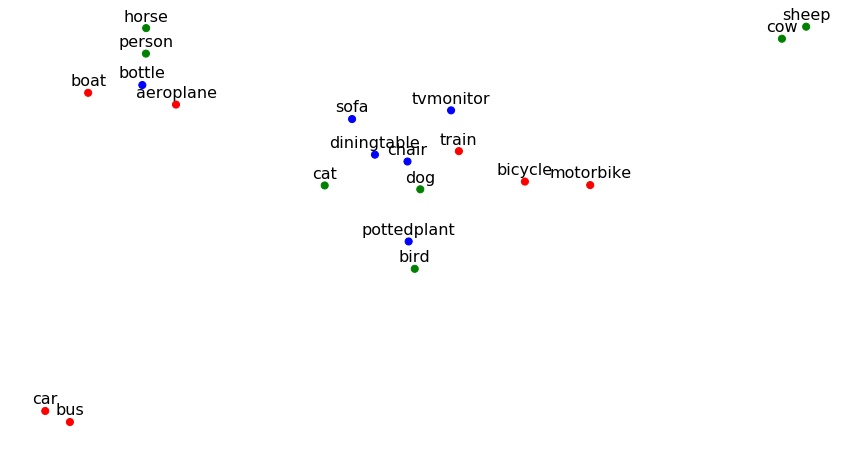

In [64]:
rep = TSNE(n_components=2, perplexity=1, early_exaggeration=4, random_state=SEED).fit_transform(clfs)

plt.figure(figsize=(15, 8))
plt.scatter(rep[:, 0], rep[:, 1], c=colors, s=50)

for i, c in enumerate(CLASSES):
    plt.annotate(c, (rep[i, 0], rep[i, 1] + 20), ha='center', fontsize=16)
    
plt.axis(False)
plt.show()